# **Final Assessment GenAI with GAN**

## ***Date: 12 June 2024***

1. Problem statement:

Anomaly detection using GAN

2. Dataset: Dataset provided by monika (link: https://github.com/venkatkumarvk/GAN_With_GenAI/blob/main/anomaly_detection_data_extended.csv)

3. Objective: Develop a GAN based model to detect anomalies in provided data (0 or 1)

4. Proposed Approach:

- Data preprocessing
- Generator Network
- Descriminator Network
- GAN Training
- Anamaly Detection
- Evaluation: Accuracy, precision, recall and F1-score

5. Framework: Pytorch

# **1. Import Necessary Library**

In [50]:
# Importing necessary libraries for TensorFlow, pandas, numpy, and matplotlib
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# Importing the PyTorch library
import torch

# Importing additional libraries for data manipulation, visualization, and machine learning
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split

# Importing PyTorch modules for neural network implementation
from torch import nn, optim
import torch.nn.functional as F
import torch.nn as nn

# Ignoring warnings to enhance code cleanliness
import warnings
warnings.filterwarnings('ignore')


# **2. Data preprocessing**

## Read the dataset and identify the dataset shape

In [51]:
df = pd.read_csv('/content/anomaly_detection_data_extended.csv')
print(f"Dataset shape: {df.shape}")
df.sample(3)


Dataset shape: (1050, 6)


,Feature1,Feature2,Feature3,Feature4,Feature5,Label
88,0.367482,-0.313530,0.921802,0.482688,0.420094,0
871,-0.281164,0.505337,0.527839,-1.899670,-0.128263,0
704,-0.213875,0.970316,0.418760,0.220584,-1.270952,0


## Amount of missing data

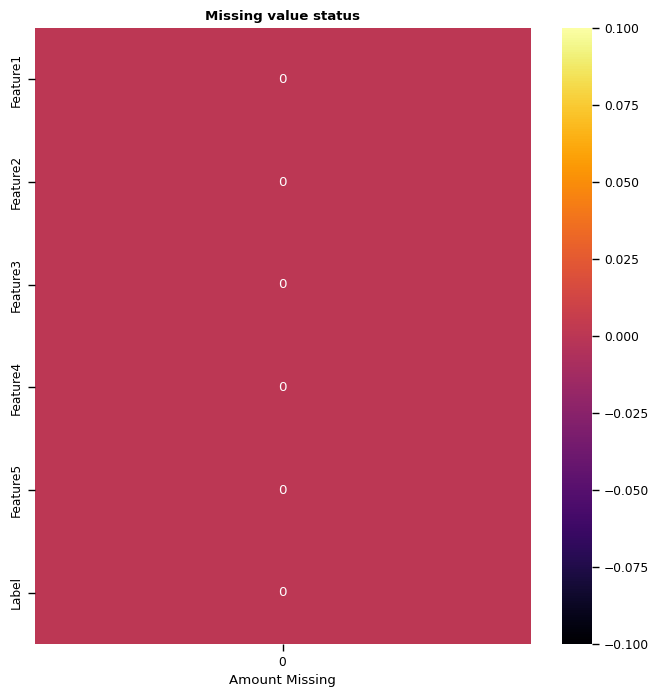

In [52]:
plt.rc('figure',figsize= (8,8))
sns.set_context('paper',font_scale=1)

plt.title('Missing value status',fontweight = 'bold')
ax = sns.heatmap(df.isnull().sum().to_frame(),annot=True,fmt = 'd',cmap = 'inferno')
ax.set_xlabel('Amount Missing')
plt.show()



## EDA

In [53]:
#statistical analysis of data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Feature1,1050.0,-0.019882,1.277914,-5.639757,-0.812861,-0.022794,0.663558,5.541150
Feature2,1050.0,-0.059497,1.193477,-5.812280,-0.772892,-0.022743,0.657066,5.303897
Feature3,1050.0,-0.003619,1.256022,-5.999366,-0.660178,-0.031479,0.691833,5.831899
Feature4,1050.0,0.018515,1.217296,-5.634041,-0.685695,0.014006,0.727188,5.963886
Feature5,1050.0,-0.013019,1.200987,-5.930752,-0.750340,-0.046650,0.707190,5.520143
Label,1050.0,0.047619,0.213060,0.000000,0.000000,0.000000,0.000000,1.000000


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Feature1  1050 non-null   float64
 1   Feature2  1050 non-null   float64
 2   Feature3  1050 non-null   float64
 3   Feature4  1050 non-null   float64
 4   Feature5  1050 non-null   float64
 5   Label     1050 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 49.3 KB


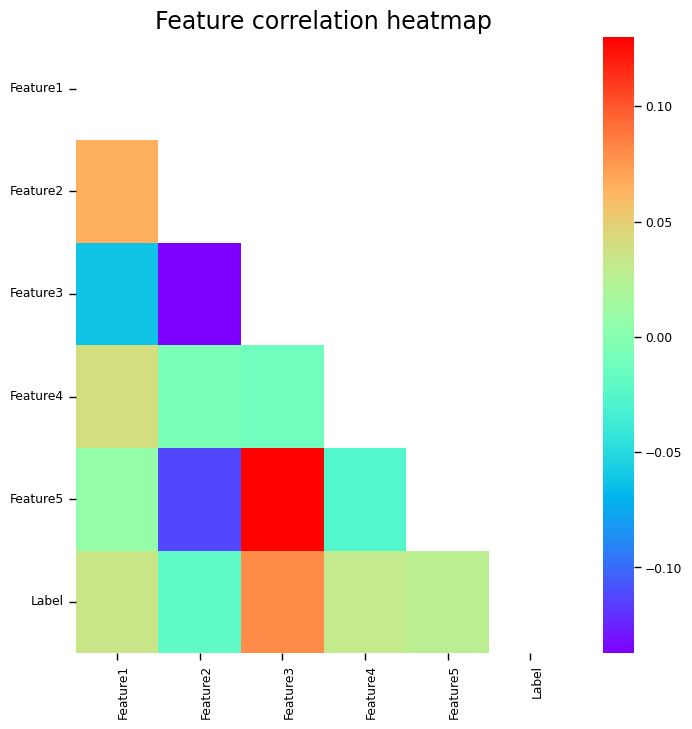

In [55]:
# Plot dataframe
heat = df.corr().round(5)

# Mask to hide upper-right part of plot as it is a duplicate
mask = np.zeros_like(heat)
mask[np.triu_indices_from(mask)] = True

# Making a plot
plt.figure(figsize=(8,8))
ax = sns.heatmap(heat, annot=False, mask=mask, cmap="rainbow", annot_kws={"weight": "bold", "fontsize":13})
ax.set_title("Feature correlation heatmap", fontsize=17)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor", weight="normal")
plt.setp(ax.get_yticklabels(), weight="normal",
         rotation_mode="anchor", rotation=0, ha="right")
plt.show();

In [56]:
df.columns

Index(['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Label'], dtype='object')

In [57]:
df.Label.value_counts()

Label
0    1000
1      50
Name: count, dtype: int64

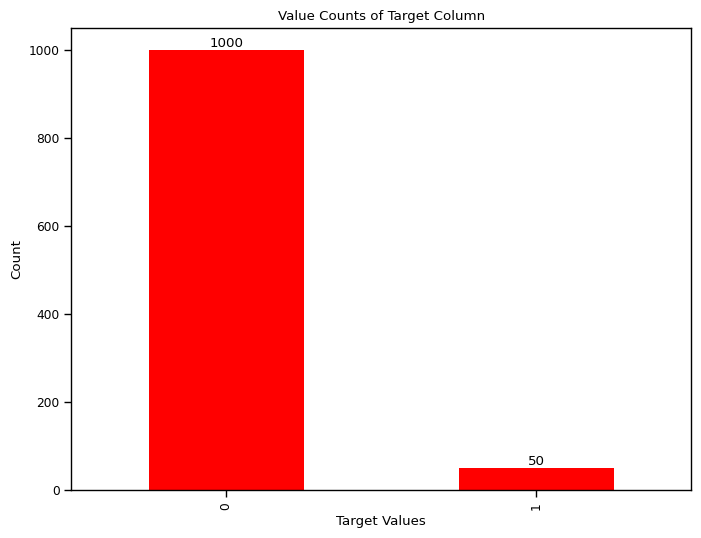

In [58]:
#plot the value count of normal and abnormal values
value_counts = df['Label'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='red')
plt.title('Value Counts of Target Column')
plt.xlabel('Target Values')
plt.ylabel('Count')

# Display the count values on top of the bars
for i, count in enumerate(value_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()

## Observation

Our data are Unbalanced manner

In [59]:

from imblearn.over_sampling import SMOTE

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

df_resampled = pd.concat([X_resampled, y_resampled], axis=1)
df = df_resampled

In [60]:
df.Label.value_counts()

Label
0    1000
1    1000
Name: count, dtype: int64

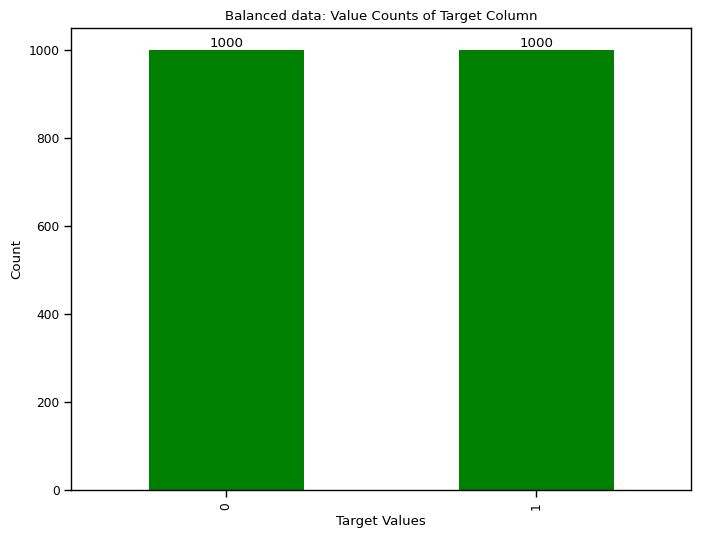

In [61]:
#plot the value count of normal and abnormal values
value_counts = df['Label'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='green')
plt.title('Balanced data: Value Counts of Target Column')
plt.xlabel('Target Values')
plt.ylabel('Count')

# Display the count values on top of the bars
for i, count in enumerate(value_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()

## Observation

Now, balanced data. I am using SMOTE method (Minority manner)

In [62]:
classes = df.Label.unique()

def plot_data(data, class_name, ax, n_steps=10):
    # Convert data to a DataFrame
    time_series_df = pd.DataFrame(data)

    # Apply a moving average for smoothing
    smooth_data = time_series_df.rolling(window=n_steps, min_periods=1).mean()

    # Calculate upper and lower bounds for confidence interval
    deviation = time_series_df.rolling(window=n_steps, min_periods=1).std()
    upper_bound = smooth_data + deviation
    lower_bound = smooth_data - deviation

    # Plot the smoothed data
    ax.plot(smooth_data, color='red', linewidth=2)

    # Plot the confidence interval
    ax.fill_between(time_series_df.index, lower_bound[0], upper_bound[0], color='black', alpha=0.2)

    # Set the title
    ax.set_title(class_name)

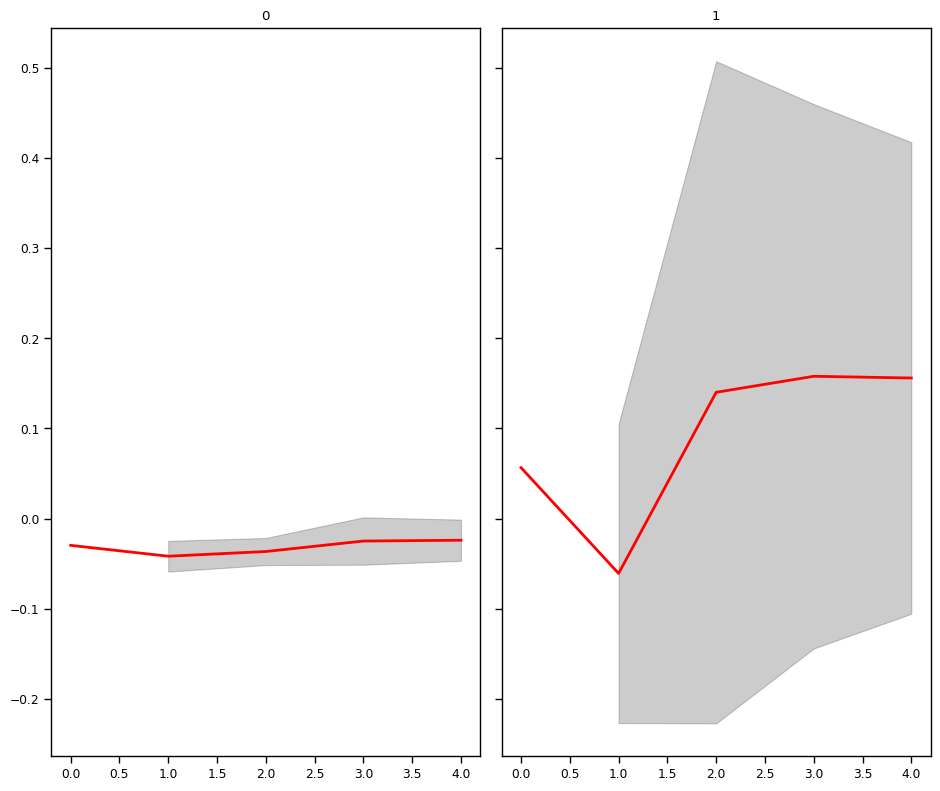

In [63]:
# Plotting setup
fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 8)
)

# Plot for each class
for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.Label == cls].drop(labels='Label', axis=1).mean(axis=0).to_numpy()
    plot_data(data, cls, ax)  # Using 'cls' directly as class name

# Adjust layout and remove extra axes
fig.delaxes(axs.flat[-1])
fig.tight_layout()

plt.show()



# **3. Preparation and Splitting of Data**

In [64]:
normal_df = df[df.Label == 1].drop(labels='Label', axis=1)
print(f"Normal: {normal_df.shape}")

anomaly_df = df[df.Label != 1].drop(labels='Label', axis=1)
print(f"Anomaly: {anomaly_df.shape}")

Normal: (1000, 5)
Anomaly: (1000, 5)


In [65]:
# Splitting the Dataset

train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=42
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.30,
  random_state=42
)

# Function to Create a Dataset
def create_dataset(df):
    # Convert DataFrame to a list of sequences, each represented as a list of floats
    sequences = df.astype(np.float32).to_numpy().tolist()

    # Convert sequences to PyTorch tensors, each with shape (sequence_length, 1, num_features)
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

    # Extract dimensions of the dataset
    n_seq, seq_len, n_features = torch.stack(dataset).shape

    # Return the dataset, sequence length, and number of features
    return dataset, seq_len, n_features



In [66]:

# Create the training dataset from train_df
train_dataset, seq_len, n_features = create_dataset(train_df)

# Create the validation dataset from val_df
val_dataset, _, _ = create_dataset(val_df)

# Create the test dataset for normal cases from test_df
test_normal_dataset, _, _ = create_dataset(test_df)

# Create the test dataset for anomalous cases from anomaly_df
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

# **4. Build the model**

Generator and Discriminator network based on LSTM manner

In [67]:
#Encoder
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

#Decoder
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)


In [68]:
# Autoencoder: Combine encoder and decoder
class Autoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Autoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = Autoencoder(seq_len, n_features, 128)
model = model.to(device)

cuda


## Helper function ploting and training the model

In [70]:
def plot_input_reconstruction(model, dataset, epoch):
    model = model.eval()

    plt.figure(figsize=(10, 5))

    # Take the first sequence from the dataset
    seq_true = dataset[0].to(device)
    seq_pred = model(seq_true)

    with torch.no_grad():
        # Squeeze the sequences to ensure they are 1-dimensional
        input_sequence = seq_true.squeeze().cpu().numpy()
        reconstruction_sequence = seq_pred.squeeze().cpu().numpy()

        # Check the shape after squeezing
        if input_sequence.ndim != 1 or reconstruction_sequence.ndim != 1:
            raise ValueError("Input and reconstruction sequences must be 1-dimensional after squeezing.")

        # Plotting the sequences
        plt.plot(input_sequence, label='Input Sequence', color='black')
        plt.plot(reconstruction_sequence, label='Reconstruction Sequence', color='red')
        plt.fill_between(range(len(input_sequence)), input_sequence, reconstruction_sequence, color='gray', alpha=0.5)

        plt.title(f'Input vs Reconstruction - Epoch {epoch}')
        plt.legend()
        plt.show()


In [71]:
def calculate_accuracy(seq_pred, seq_true):
    # Calculate Mean Absolute Error
    mae = torch.mean(torch.abs(seq_pred - seq_true))
    # Calculate accuracy as the inverse of Mean Absolute Error
    accuracy = 1.0 - mae.item() / torch.max(seq_true).item()
    return accuracy

def train_model(model, train_dataset, val_dataset, n_epochs, save_path):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    best_accuracy = 0.0

    for epoch in range(1, n_epochs + 1):
        model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        val_accuracies = []
        model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                accuracy = calculate_accuracy(seq_pred, seq_true)

                val_losses.append(loss.item())
                val_accuracies.append(accuracy)

            val_loss = np.mean(val_losses)
            val_accuracy = np.mean(val_accuracies)

            history['train_loss'].append(np.mean(train_losses))
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)

            if val_loss < best_loss:
                best_loss = val_loss
                best_accuracy = val_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save the best model weights
                print("Saving best model")
                torch.save(model.state_dict(), save_path)

            print(f'Epoch {epoch}: train loss {history["train_loss"][-1]}, val loss {val_loss}, val accuracy {val_accuracy}')

            if epoch == 1 or epoch % 5 == 0:
                plot_input_reconstruction(model, val_dataset, epoch)

    # Load the best model weights before returning
    model.load_state_dict(best_model_wts)
    return model.eval(), history


# **5. Train the model and store the best model in locally**

Saving best model
Epoch 1: train loss 1.3705667431038968, val loss 1.5454788088798523, val accuracy 0.9607849767843105


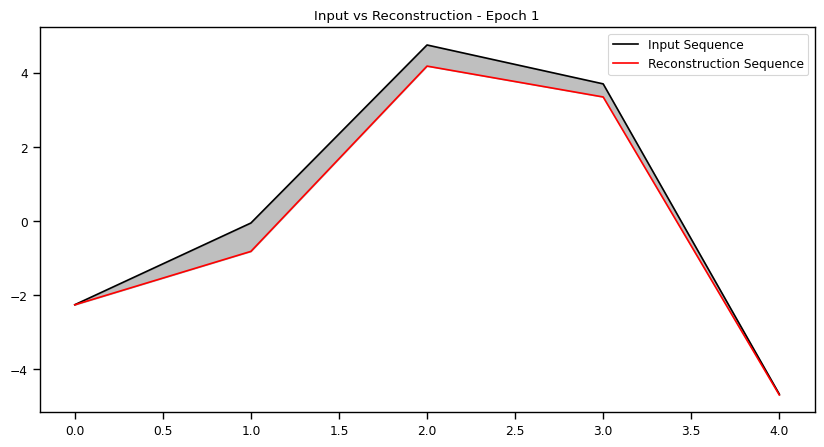

Saving best model
Epoch 2: train loss 1.3829014632281136, val loss 1.5171580990155538, val accuracy 0.9486250307472918
Epoch 3: train loss 1.3466869311122334, val loss 1.5933154438223158, val accuracy 0.9409222478622523
Saving best model
Epoch 4: train loss 1.2440715064371333, val loss 1.3371517774604615, val accuracy 0.9411180218499602
Epoch 5: train loss 1.2476206288092277, val loss 1.4164963889689672, val accuracy 0.9391506429657972


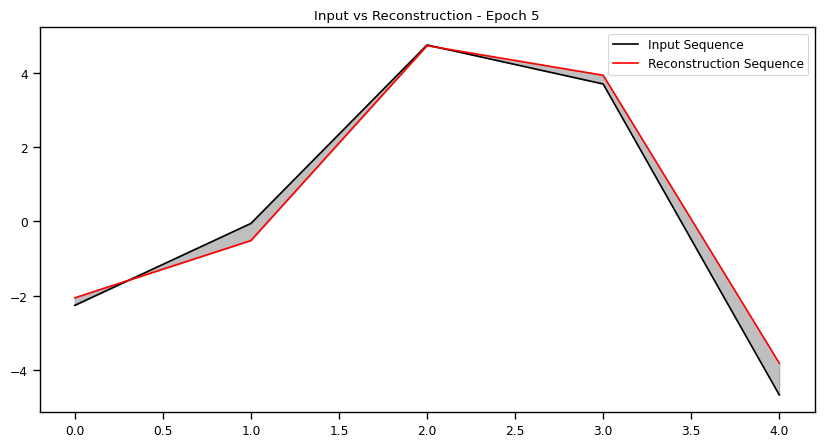

Epoch 6: train loss 1.231074531849693, val loss 1.386543668735595, val accuracy 0.9764709884239015
Saving best model
Epoch 7: train loss 1.1822284766505746, val loss 1.3075945346128373, val accuracy 0.9546831384536665
Epoch 8: train loss 1.2157723071645288, val loss 1.3114300611473264, val accuracy 0.9601836678419498
Epoch 9: train loss 1.140593053979032, val loss 1.3294951237383343, val accuracy 0.9544216655152892
Epoch 10: train loss 1.1459676750617869, val loss 1.3380543762729282, val accuracy 0.9786623192568895


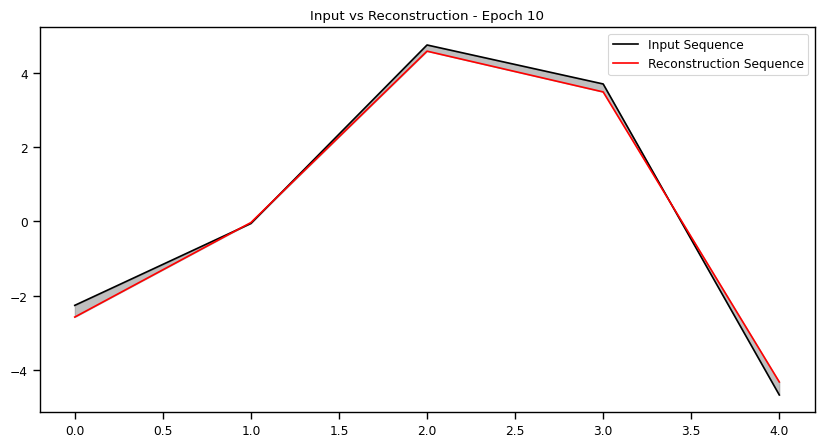

Saving best model
Epoch 11: train loss 1.1478588128791136, val loss 1.234099493140266, val accuracy 0.95098062735574
Epoch 12: train loss 1.0843648565867368, val loss 1.5187499213786353, val accuracy 0.9396846414990568
Epoch 13: train loss 1.0843409820865182, val loss 1.2569885842856907, val accuracy 0.9465187690482718
Epoch 14: train loss 1.0890670972185976, val loss 1.267396981517474, val accuracy 0.9704241068808497
Epoch 15: train loss 1.0744436474056804, val loss 1.2384007598672595, val accuracy 0.9649223400310154


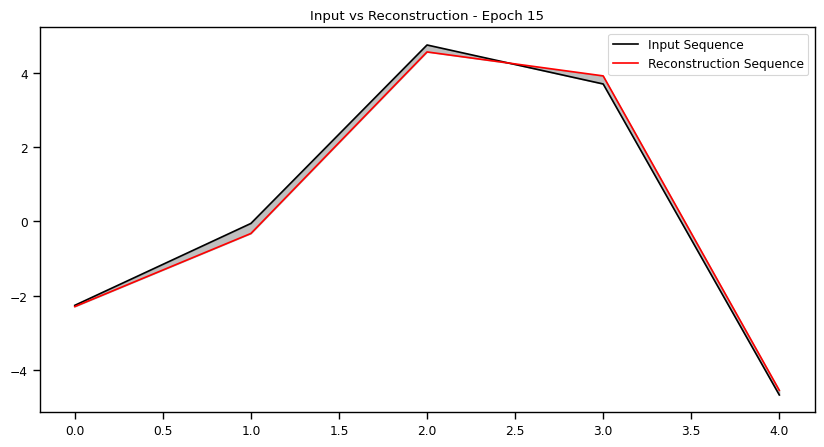

Saving best model
Epoch 16: train loss 1.0505116447105127, val loss 1.1308048634302048, val accuracy 0.9469742403765243
Epoch 17: train loss 1.0035935554960196, val loss 1.217970489320301, val accuracy 0.9563629338238253
Epoch 18: train loss 1.0041259199906798, val loss 1.2417937335513887, val accuracy 0.9566965566804556
Epoch 19: train loss 0.9970701202574899, val loss 1.2457348606416156, val accuracy 0.9530890519846587
Epoch 20: train loss 0.9840891558282515, val loss 1.1961578394685473, val accuracy 0.9499011896656661


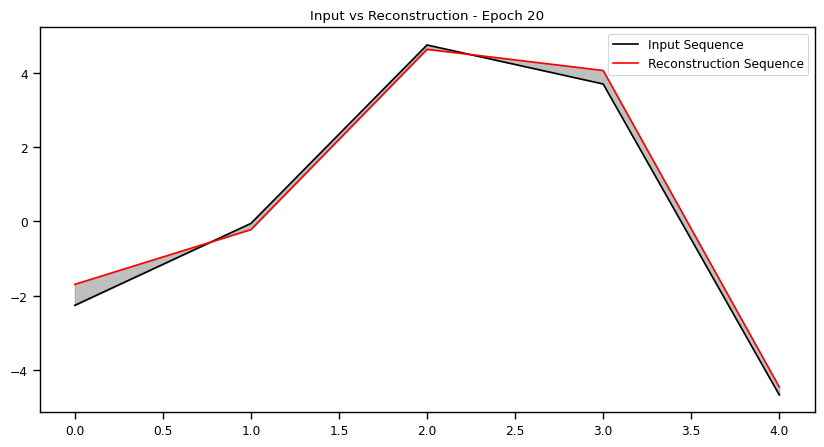

Epoch 21: train loss 1.0026282802048851, val loss 1.3193975757984888, val accuracy 0.9416339198853879
Saving best model
Epoch 22: train loss 0.9853314736660789, val loss 1.0576178573426747, val accuracy 0.9670198020176642
Epoch 23: train loss 0.9516046736345571, val loss 1.1118208936282568, val accuracy 0.9589433577384143
Epoch 24: train loss 0.9271912998486967, val loss 1.0658222147396632, val accuracy 0.9634518340281293
Saving best model
Epoch 25: train loss 0.919306970764609, val loss 1.0472136874993643, val accuracy 0.9704720172215288


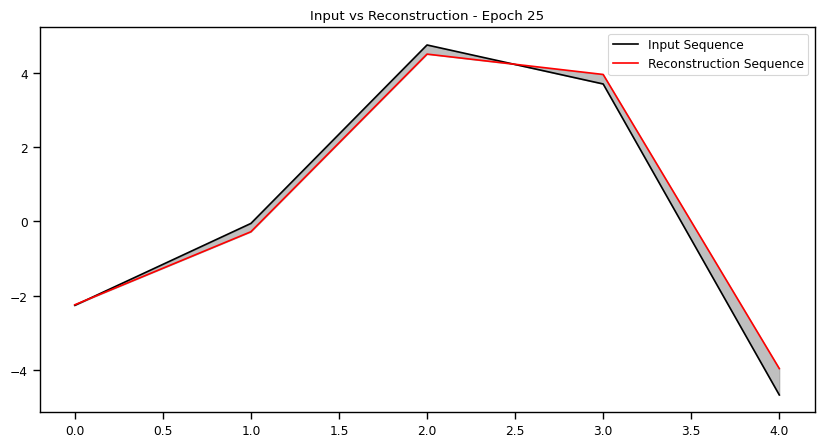

In [73]:
save_path = '/content/best_model.pth'  # Replace with your actual path
model, history = train_model(model, train_dataset, val_dataset, 25, save_path)


## Training vs validation Loss

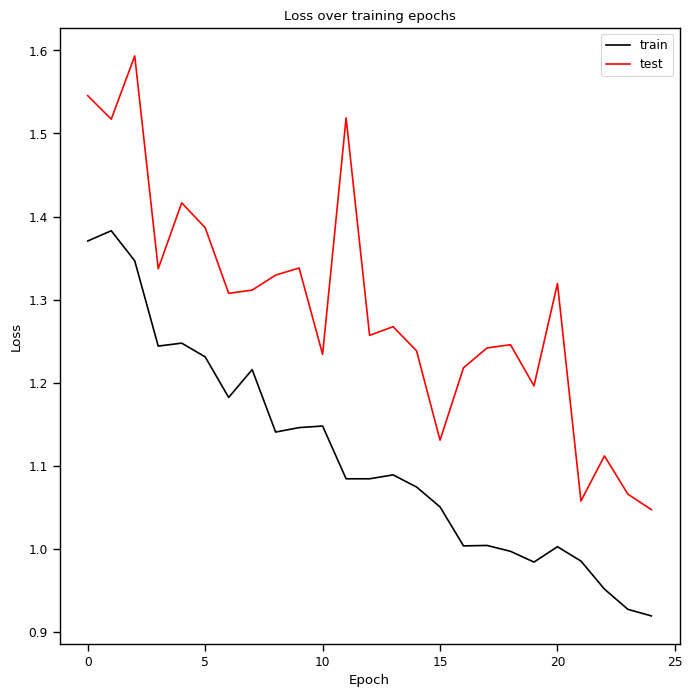

In [74]:
ax = plt.figure().gca()

ax.plot(history['train_loss'],label='Train Loss', color='black')
ax.plot(history['val_loss'],label='Val Loss', color='red')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

Without handling in balancing data: Our model is worst at the moment, main reason is unbalanced data. we will tackle this problem. its give the good result

Handling inbalance data: its gives the good result

# Anomaly Detection Model: Evaluation and Visualization (Accuracy)


In [78]:
model = Autoencoder(seq_len, n_features, 128)
#use best model
model.load_state_dict(torch.load('/content/best_model.pth'))

model = model.to(device)
model.eval()


Autoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [79]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

def calculate_accuracy(predictions, dataset):
    accuracies = []
    for pred, true in zip(predictions, dataset):
        true = true.cpu().numpy().flatten()
        mae = np.mean(np.abs(pred - true))
        accuracy = 1.0 - mae / np.max(true)
        accuracies.append(accuracy)
    return np.mean(accuracies)


In [80]:
predictions,losses = predict(model, train_dataset)
accuracy = calculate_accuracy(predictions, train_dataset)
print(f"Accuracy of the model on the train dataset: {accuracy}")


Accuracy of the model on the train dataset: 0.9799107298123486


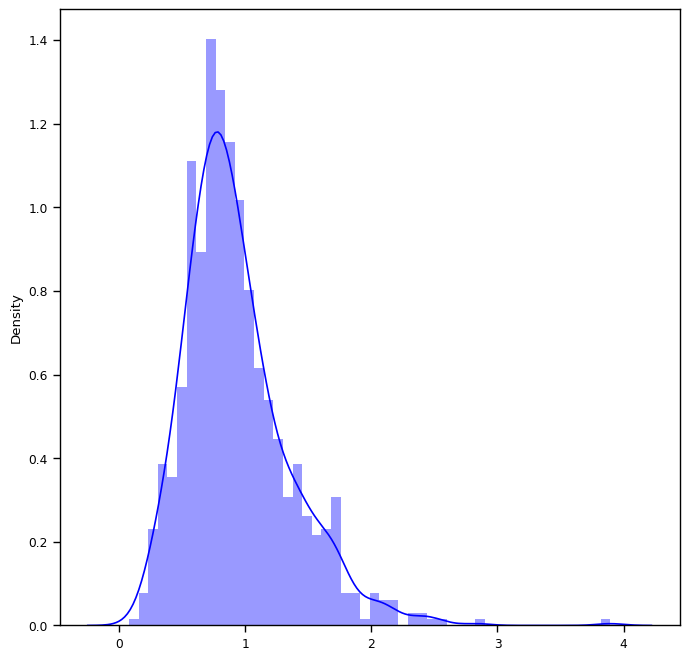

In [81]:
sns.distplot(losses, bins=50, kde=True, label='Train',color='blue');


Accuracy of the model on the validation dataset: -0.280420630507999


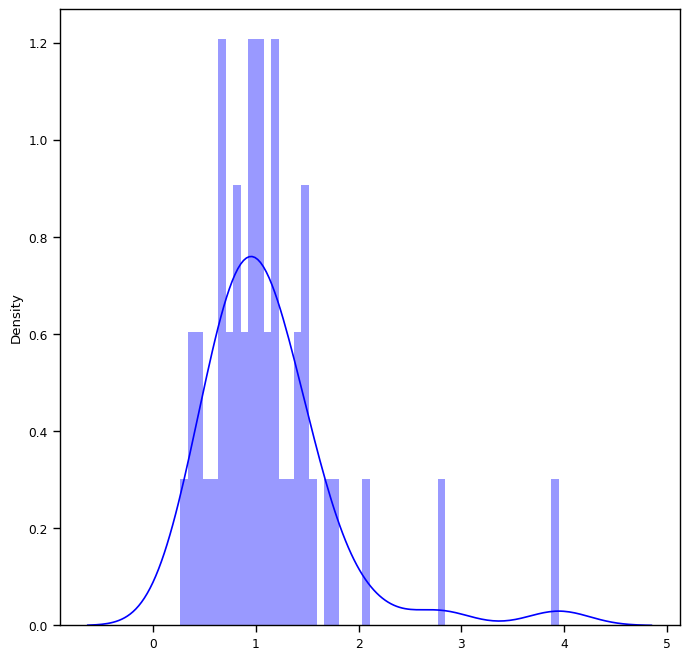

In [83]:
Threshold = 25
predictions, pred_losses = predict(model, test_normal_dataset)
accuracy = calculate_accuracy(predictions, val_dataset)
print(f"Accuracy of the model on the validation dataset: {accuracy}")
sns.distplot(pred_losses, bins=50, kde=True,color='blue');

In [84]:

correct = sum(l <= 25 for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 45/45


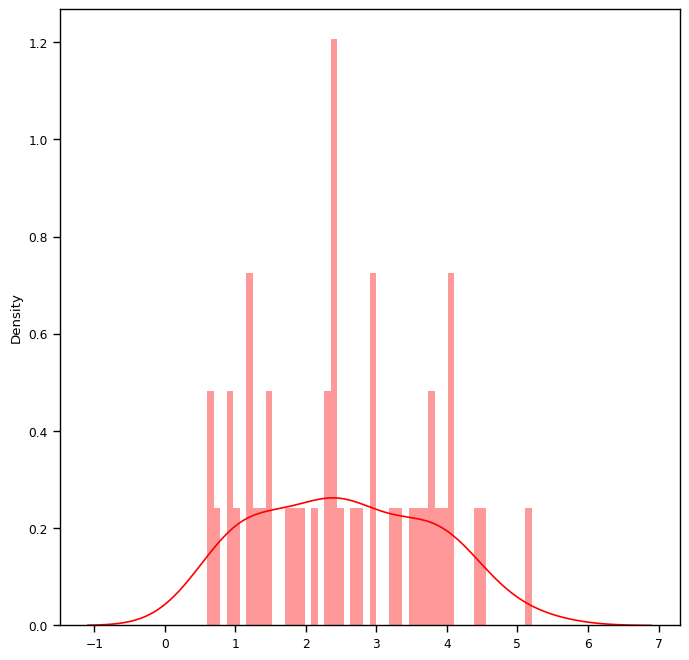

In [85]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True,color='red');


In [86]:

correct = sum(l > 25 for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 0/45


-----------------------------------


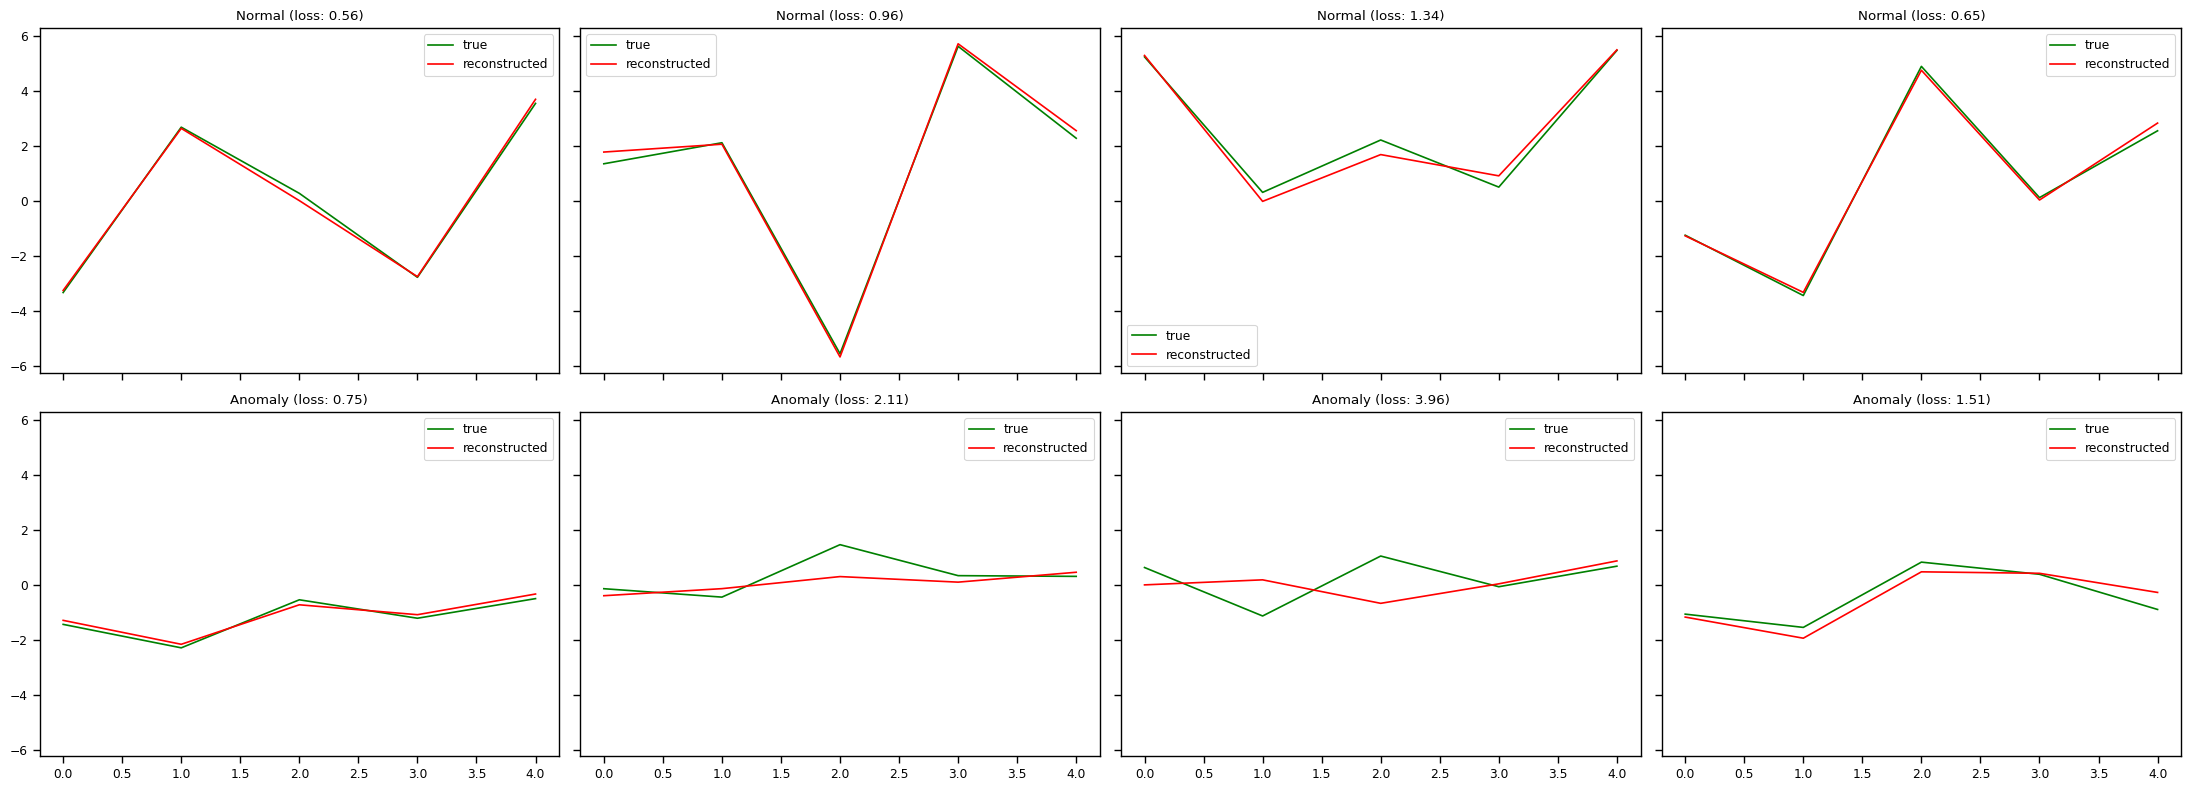

In [87]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true',color='green')
  ax.plot(predictions[0], label='reconstructed',color='red')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

print("-----------------------------------")

fig, axs = plt.subplots(
  nrows=2,
  ncols=4,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:4]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:4]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

# Final Observation:

1. Increase the epoch and increase the accuracy and reduce the losses
2. Hyperparameter changing is require if you want to increase the accuracy and good result of our project
3. If model not work well in real time, change the architecture and  explore the all hyperparameters change to evaluate the model.

Tackling issues,

1. Initial my developement, Main disadvantage is unbalanced data, so Our model is predict bad result. If you want to develop the good manner. We preprocess to change data in balanced manner.

- Without handling of unbalanced data, i got 0.15 accuracy result

2. Second I balanced the data, And develop the model its good comparable to previous method.

- Handling inbalance data, Now i got above 90 percent accuracy.

# **Happy learning**


Reference:

1. https://github.com/monika-4dec/AI-Fundamentals-Updated/blob/main/GANs/Day%203_4autoencoder.ipynb
2. https://adamoudad.github.io/posts/ecg-anomaly-detection/